In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from tensorflow.keras.models import load_model

In [3]:
df = pd.read_csv("data/indexProcessed.csv", parse_dates=["Date"])
df = df.sort_values('Date').reset_index(drop=True)

data = df[['CloseUSD']].values

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [12]:
import os
os.makedirs("model", exist_ok=True)

In [14]:
joblib.dump(scaler, "model/scaler.pkl")

['model/scaler.pkl']

In [16]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

In [18]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [20]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [22]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[es])

Epoch 1/50
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 99s 36ms/step - loss: 0.0207 - val_loss: 0.0886
Epoch 2/50
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 94s 36ms/step - loss: 0.0198 - val_loss: 0.0848
Epoch 3/50
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 87s 33ms/step - loss: 0.0197 - val_loss: 0.0859
Epoch 4/50
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 86s 33ms/step - loss: 0.0195 - val_loss: 0.0805
Epoch 5/50
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 88s 34ms/step - loss: 0.0195 - val_loss: 0.0814
Epoch 6/50
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 84s 32ms/step - loss: 0.0195 - val_loss: 0.0783
Epoch 7/50
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 103s 40ms/step - loss: 0.0197 - val_loss: 0.0820
Epoch 8/50
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 95s 36ms/step - loss: 0.0197 - val_loss: 0.0824
Epoch 9/50
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 91s 35ms/step - loss: 0.0194 - val_loss: 0.0816
Epoch 10/50
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 92s 35ms/step - loss: 0.0195 - val_loss: 0.0796
Epoch 11/50
2605/2605 ━━━━━━━━━━━━━━━━━━━━ 92s 35ms/step - loss: 0.0195 - val_loss: 0.0824


In [25]:
model.save("model/stock_model.h5")

652/652 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step


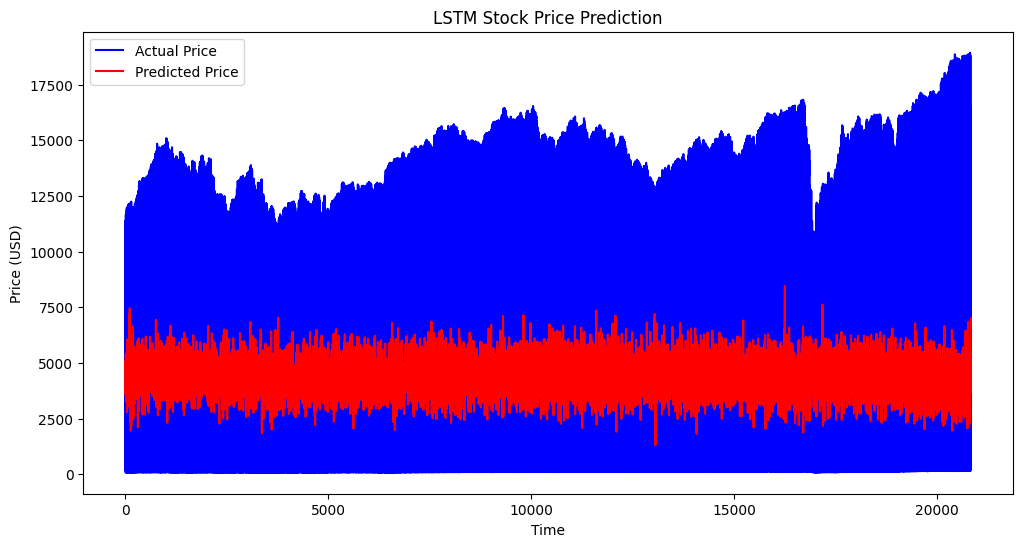

In [26]:
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual Price', color='blue')
plt.plot(predicted, label='Predicted Price', color='red')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()